# Tvorba obchodní strategie - křížení klouzavých průměrů

## Informace o notebooku a modulech

In [2]:
NB_VERSION = 1,0

import sys
import datetime
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as pdr_web
import quandl as ql
from matplotlib import __version__ as matplotlib_version
from seaborn import __version__ as seaborn_version
import statsmodels.api as sm

# Load Quandl API key
import json
with open('quandl_key.json','r') as f:
    quandl_api_key = json.load(f)
ql.ApiConfig.api_key = quandl_api_key['API-key']

print('Verze notebooku:', '.'.join(map(str, NB_VERSION)))
print('Verze pythonu:', '.'.join(map(str, sys.version_info[0:3])))
print('---')
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('pandas-datareader:', pdr.__version__)
print('Quandl:', ql.version.VERSION)
print('Matplotlib:', matplotlib_version)
print('Seaborn:', seaborn_version)
print('Statsmodels:', sm.version.version)

Verze notebooku: 1.0
Verze pythonu: 3.6.2
---
NumPy: 1.13.1
Pandas: 0.20.3
pandas-datareader: 0.4.0
Quandl: 3.1.0
Matplotlib: 2.0.2
Seaborn: 0.8.0
Statsmodels: 0.8.0


# Rychlý přehled základních běžných typů strategií

Pro automatické obchodování, které využívá *analýzu dat*, se používá termín [**Quantitative trading**](http://www.investopedia.com/terms/q/quantitative-trading.asp). Běžně a nejčastěji se v obchodování se používají dva typy strategií:

## Strategie založené na momentu (momentum strategy)

Zde spadají jak **trendové strategie**, tak i **strategie na principu divergencí**. V případě obchodování těchto typů strategií spoléháme, že aktuální pohyb trhu bude pokračovat ve stejném směru i v budoucnosti. Zároveň věříme, že tyto trendy dokážeme detekovat a následně využít. Jako příklad takové strategií jsou strategie na bázi *křížení klouzavých průměrů (moving average crossover)*.

## Reverzní strategie (reversion strategy)

Někdy se jim říká také **strategie konvergence** (covergence) nebo **strategie burzovních cyklů** (cycle trading). Tyto strategie zakládají na myšlence, že aktuální pohyb může eventuálně začít reversovat. Jako příklad může posloužit *strategie založená na principu návratu k průměrné ceně (mean reversion strategy)*.

# Strategie na principu křížení klouzavých průměrů

Ta nejjednodušší strategie, kterou lze vytvořit, je křížení klouzavých průměrů.

Využiji dva jednoduché klouzavé průměry *(SMA - simple moving average)* s rozdílnými periodami, např. 30 a 90 dní. Pro pozici `long` chci vidět překřížení `SMA s kratší periodou` *směrem nahoru přes* `SMA s delší periodou`. Pro pozici `short` chci vidět překřížení `SMA s kratší periodou` směrem *dolů* přes `SMA s delší periodou`. 


**Postup**
1. Získám data trhu, kterého chci obchodovat a ty si vložím do proměnné `ohlc_data`. 
+ Definuji si periody pro kratší a delší `SMA` do proměnných `short_period` a `long_period`.
+ Vytvořím si signální `DataFrame`, který bude mít sloupec `signal`. Jen musím zajistit, aby indexy v `signals` odpovídaly s index v `ohlc_data`.
+ Pomocí `rolling()` a `mean()` funkcí vypočítám SMA pro kratší a delší periodu.
+ Do `signals['signal']` vložím 1.0 pro dny, kde SMA s kratší periodou je nad SMA s delší periodou. Tento signál musím počítat od pozice, kdy je platná vypočítaná hodnota pro SMA s kratší periodou, tj. od řádku s číslem vloženým v `short_period`.
+ Nakonec do `signals['positions']` vložím rozdíl změny, kdy se mění hodnota ve sloupečku `'signal'`. Tím získám velikost pozice v jaké bych měl být pro strategii klouzavých průměrů -> pro long je hodnota `1.0`, pro short je to `-1.0`.

In [3]:
# Zíkám data ETF trhu SPY, který kopíruje trh S&P 500
start_date = datetime.datetime(2008, 1, 1)
end_date = datetime.datetime.now()
ohlc_data = pdr_web.DataReader("NYSEARCA:SPY", 'google', start=start_date, end=end_date)

# Příprava period pro SMA
short_period = 30
long_period = 90

# Připrava signálního DataFrame s vynulovaným sloupcem 'signal', 0=bez signálu
signals = pd.DataFrame(index=ohlc_data.index)
signals['signal'] = 0.0

# SMA pro kratší a delší periodu.
signals['short_sma'] = ohlc_data['Close'].rolling(window=short_period, min_periods=1, center=False).mean()
signals['long_sma'] = ohlc_data['Close'].rolling(window=long_period, min_periods=1, center=False).mean()

# Získání signálu pro situace, kde SMA s menší periodou je nad SMA s větší periodou.
signals['signal'][short_period:] = np.where(signals['short_sma'][short_period:] 
                                            > signals['long_sma'][short_period:], 1.0, 0.0)   

# Vygenerování obchodních příkazů
signals['positions'] = signals['signal'].diff()

**Vypočítané long pozice**

In [4]:
signals[signals['positions']>0]

,signal,short_sma,long_sma,positions
Date,,,,
2008-04-29,1.0,135.679667,135.578780,1.0
2009-04-27,1.0,82.639000,82.591111,1.0
2010-03-16,1.0,111.154667,111.112111,1.0
2010-09-13,1.0,109.438000,109.382111,1.0
2011-11-11,1.0,122.062333,121.969222,1.0
2012-08-03,1.0,135.652333,135.620444,1.0
2013-01-07,1.0,142.826667,142.761889,1.0
2014-11-19,1.0,197.635333,197.563556,1.0
2015-11-10,1.0,203.749000,203.123000,1.0


**Vypočítané short pozice**

In [5]:
signals[signals['positions']<0]

,signal,short_sma,long_sma,positions
Date,,,,
2008-06-30,0.0,135.992000,136.015778,-1.0
2010-02-25,0.0,110.036333,110.111222,-1.0
2010-06-04,0.0,113.729667,114.037111,-1.0
2011-06-15,0.0,132.165000,132.175778,-1.0
2012-05-24,0.0,136.307000,136.480111,-1.0
2012-11-20,0.0,141.392000,141.423667,-1.0
2014-10-16,0.0,196.376667,196.526556,-1.0
2015-07-10,0.0,209.359667,209.429333,-1.0
2016-01-14,0.0,202.199000,202.315222,-1.0


# Zobrazení výsledků

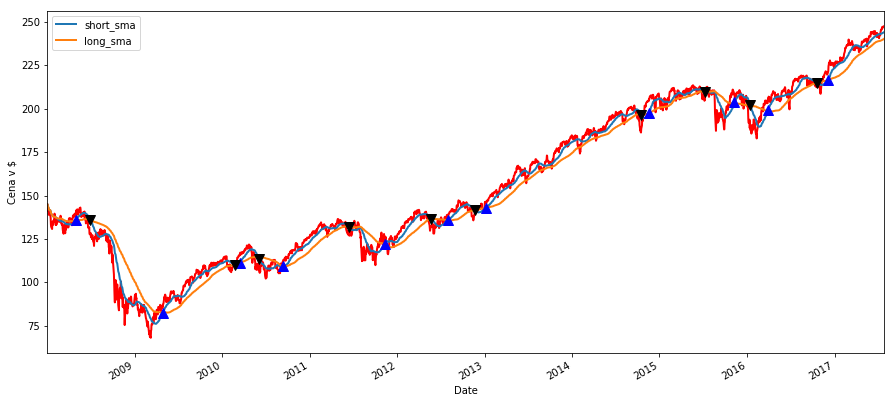

In [6]:
import matplotlib.pyplot as plt

# Příprava oblasti grafu
fig = plt.figure(figsize=(15,7))

# Přidání grafu s pojmenovanou osou y do oblasti grafu
ax1 = fig.add_subplot(111,  ylabel='Cena v $')

# Přidání vývoje Close ceny do grafu.
ohlc_data['Close'].plot(ax=ax1, color='r', lw=2.)

# Přidání vývoje klouzavých průměrů do grafu.
signals[['short_sma', 'long_sma']].plot(ax=ax1, lw=2.)

# Přidání vstupních signálů "buy"
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_sma[signals.positions == 1.0],
         '^', markersize=10, color='b')
         
# Přidání vstupních signálů "sell"
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_sma[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Zobrazení grafu
plt.show()

**černá** - short pozice  
**modrá** - long pozice


>**TIP:** Pokud se kód výše zdá moc složitý, je vhodné jednotlivé příkazy si spustit postupně a zobrazit si jednotlivé výsledky pro rychlejší pochopení.

# Závěr

Strategie na bázi klouzavých průměrů jsou něco jako *Hello world!* pro programátory. Je to ale příklad, u kterého není třeba nic extra vymýšlet a velmi jednoduchý ukázkový systém lze připravit za pár minut s použitím malého množství kódu.

[Alex Bellos](http://www.alexbellos.com/) ve své knize *Alex za zrcadlem - Jak se čísla odrážejí v životě a život v číslech* popisuje, že i velmi jednoduché principy mohou dávat velmi komplexní výsledky. Zde nechám otevřený konec: **Dá se využít výše zmíněná strategie na principu klouzavých průměrů k přiblížení se k reálným ziskům?**

## Seznam zdrojů:
1. [Pandas - manipulace a analýza dat](https://pandas.pydata.org/)
+ [pandas-datareader](https://github.com/pydata/pandas-datareader)
+ [Seznam všech webových zdrojů v pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html)
+ [Python For Finance: Algorithmic Trading](https://www.datacamp.com/community/tutorials/finance-python-trading)
+ [Quandl](https://www.quandl.com/)
+ [ETF trhy - finančník](http://www.financnik.cz/komodity/financnik/trhy-podrobneji-etfs.html)
+ [Matplotlib](https://matplotlib.org/)
+ [Seaborn](https://seaborn.pydata.org/)
+ [Statsmodels](http://www.statsmodels.org)
+ [Jupyter markdown syntax](https://sourceforge.net/p/jupiter/wiki/markdown_syntax/)
+ [Alex Bellos](http://www.alexbellos.com/)